In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import timeit
import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Input data
data = np.load('Data//model_data.npy.npz')
pPriceDA = data['arr_0']
pPV = data['arr_1']
pPricePosImb = data['arr_2']
pPriceNegImb = data['arr_3']
n_pv = data['arr_4'].item()
n_dam = data['arr_5'].item()
n_imb = data['arr_6'].item()

In [3]:
pPricePosImb[0,0]

48.73

In [4]:
# PV installed power
pPmax = 2.0

In [5]:
# Total number of periods and scenarios
nperiods = 24
nscenarios = n_pv*n_dam*n_imb
# Probability vector
pi = 1/nscenarios # Equiprobable scenarios
pProb = [pi for i in range(nscenarios)]

In [6]:
# Gurobipy model
model = gp.Model('PVmodel')
vBid = model.addVars(nperiods, vtype=GRB.CONTINUOUS, name='bid')
vImbalanceVol = model.addVars(nperiods, nscenarios, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name='Imbalance_Volume')
vPosImbalanceVol = model.addVars(nperiods, nscenarios, vtype=GRB.CONTINUOUS, name='Positive_Imbalance_Volume')
vNegImbalanceVol = model.addVars(nperiods, nscenarios, vtype=GRB.CONTINUOUS, name='Negative_Imbalance_Volume')
vBinaryImb = model.addVars(nperiods, nscenarios, vtype=GRB.BINARY, name='Binary_Imbalance_Var')


--------------------------------------------
--------------------------------------------

Using license file C:\Users\Antun\gurobi.lic
Academic license - for non-commercial use only


In [7]:
# Objective function
time_start = timeit.default_timer()

profit = gp.quicksum(pProb[s]*(pPriceDA[t][s]*vBid[t] + pPricePosImb[t][s]*vPosImbalanceVol[t,s] - \
                     pPriceNegImb[t][s]*vNegImbalanceVol[t,s]) for t in range(nperiods) for s in range(nscenarios))
model.setObjective(profit, GRB.MAXIMIZE)

time_end = timeit.default_timer()
time_elapsed = time_end - time_start
print('Execution time (hour:min:sec): {}'.format(str(datetime.timedelta(seconds=time_elapsed))))

Execution time (hour:min:sec): 0:00:00.048349


In [8]:
# Constraints
time_start = timeit.default_timer()

model.addConstrs(vImbalanceVol[t,s] == pPV[t][s] - vBid[t] 
                 for t in range(nperiods) for s in range(nscenarios))
model.addConstrs(vImbalanceVol[t,s] == vPosImbalanceVol[t,s] - vNegImbalanceVol[t,s]
                 for t in range(nperiods) for s in range(nscenarios))
model.addConstrs(vPosImbalanceVol[t,s] <= vBinaryImb[t,s]*pPmax
                 for t in range(nperiods) for s in range(nscenarios))
model.addConstrs(vNegImbalanceVol[t,s] <= (1-vBinaryImb[t,s])*pPmax 
                 for t in range(nperiods) for s in range(nscenarios))
model.addConstrs(vBid[t] <= pPmax for t in range(nperiods))

time_end = timeit.default_timer()
time_elapsed = time_end - time_start
print('Execution time (hour:min:sec): {}'.format(str(datetime.timedelta(seconds=time_elapsed))))

Execution time (hour:min:sec): 0:00:00.036651


In [9]:
time_start = timeit.default_timer()

model.optimize()

time_end = timeit.default_timer()
time_elapsed = time_end - time_start
print('Execution time (hour:min:sec): {}'.format(str(datetime.timedelta(seconds=time_elapsed))))

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 888 rows, 888 columns and 1968 nonzeros
Model fingerprint: 0xff6cd73a
Variable types: 672 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 2e+00]
Found heuristic solution: objective 142.8272565
Presolve removed 861 rows and 860 columns
Presolve time: 0.02s
Presolved: 27 rows, 28 columns, 72 nonzeros
Found heuristic solution: objective 153.2949715
Variable types: 19 continuous, 9 integer (9 binary)

Root relaxation: objective 1.533021e+02, 21 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     153.3020873  153.30209  0.00%     -    0s

Explored 0 nodes (21 simplex iterations) in 0.04 seconds
Thread count was 4 (of 4 a

In [10]:
vBidvals = []
for index in vBid.keys():
    vBidvals.append(vBid[index].x)
vBidvals = pd.Series(vBidvals)

In [11]:
vNegImbVol = pd.DataFrame()
vPosImbVol = pd.DataFrame()
vImbVol = pd.DataFrame()
vBinImb = pd.DataFrame()

for period, scenario in vNegImbalanceVol.keys():
    vNegImbVol.loc[period, scenario] = vNegImbalanceVol[period, scenario].x
    vPosImbVol.loc[period, scenario] = vPosImbalanceVol[period, scenario].x
    vImbVol.loc[period, scenario] = vImbalanceVol[period, scenario].x
    vBinImb.loc[period, scenario] = vBinaryImb[period, scenario].x

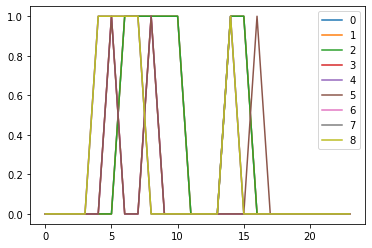

In [12]:
vBinImb.plot()

In [13]:
print(model.getObjective().getValue())

153.30208730125565


In [14]:
model.getObjective()

<gurobi.LinExpr: 41.629999999999995 bid[0] + 38.19333333333333 bid[1] + 36.18333333333334 bid[2] + 27.603333333333335 bid[3] + 37.69 bid[4] + 43.18333333333334 bid[5] + 49.36666666666666 bid[6] + 54.19333333333333 bid[7] + 55.91666666666667 bid[8] + 50.75333333333332 bid[9] + 45.45333333333333 bid[10] + 49.813333333333325 bid[11] + 50.123333333333335 bid[12] + 47.536666666666655 bid[13] + 46.056666666666665 bid[14] + 42.449999999999996 bid[15] + 47.79333333333333 bid[16] + 43.25666666666667 bid[17] + 52.50666666666667 bid[18] + 53.279999999999994 bid[19] + 52.02666666666666 bid[20] + 49.66666666666667 bid[21] + 44.89666666666667 bid[22] + 29.273333333333333 bid[23] + 5.4144444444444435 Positive_Imbalance_Volume[0,0] + 4.34 Positive_Imbalance_Volume[0,1] + 4.122222222222222 Positive_Imbalance_Volume[0,2] + 5.4144444444444435 Positive_Imbalance_Volume[0,3] + 4.34 Positive_Imbalance_Volume[0,4] + 4.122222222222222 Positive_Imbalance_Volume[0,5] + 5.4144444444444435 Positive_Imbalance_Volu

In [49]:
vNegImbVol.T.drop_duplicates().T.drop(1, axis=1)

0         3         6
0   0.000000  0.000000  0.000000
1   0.000000  0.000000  0.000000
2   0.000000  0.000000  0.000000
3   0.000000  0.000000  0.000000
4   0.000000  0.000000  0.000000
5   0.000000  0.000000  0.000000
6   0.000000  0.000000  0.000000
7   0.000000  0.000000  0.000000
8   0.000000  0.000000  0.000000
9   0.000000  0.000000  0.211752
10  0.000000  0.000000  0.473671
11  0.000000  0.601180  0.593990
12  0.000000  0.392673  0.508380
13  0.000000  0.333160  0.533221
14  0.000000  0.000000  0.000000
15  0.000000  0.000000  0.090316
16  0.010640  0.000000  0.046353
17  0.003395  0.000000  0.000446
18  0.000000  0.000000  0.000000
19  0.000000  0.000000  0.000000
20  0.000000  0.000000  0.000000
21  0.000000  0.000000  0.000000
22  0.000000  0.000000  0.000000
23  0.000000  0.000000  0.000000

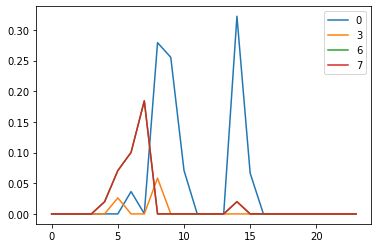

In [31]:
vPosImbVol.T.drop_duplicates().T.plot()

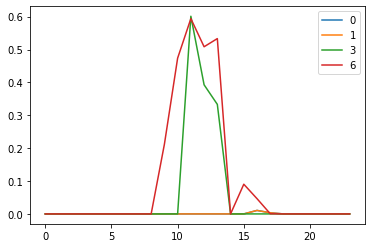

In [16]:
vNegImbVol.T.drop_duplicates().T.plot()

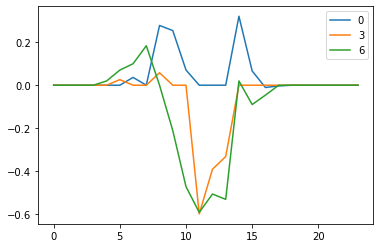

In [17]:
vImbVol.T.drop_duplicates().T.plot()

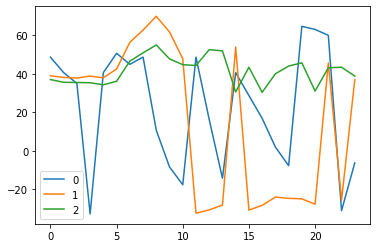

In [57]:
pd.DataFrame(pPricePosImb).T.drop_duplicates().T.plot()

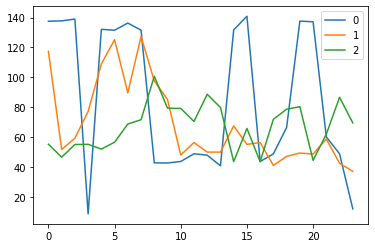

In [19]:
pd.DataFrame(pPriceNegImb).T.drop_duplicates().T.plot()

In [20]:
PV1 = pPV[:, 0]
PV2 = pPV[:, n_dam*n_imb]
PV3 = pPV[:, n_pv*n_dam*n_imb-1]

In [21]:
DAM1 = pPriceDA[:,0]
DAM2 = pPriceDA[:,1]
DAM3 = pPriceDA[:,2]

In [22]:
PosImbPrice1 = pPricePosImb[:, 0]
PosImbPrice2 = pPricePosImb[:, 1]
PosImbPrice3 = pPricePosImb[:, 2]

In [23]:
NegImbPrice1 = pPriceNegImb[:, 0]
NegImbPrice2 = pPriceNegImb[:, 1]
NegImbPrice3 = pPriceNegImb[:, 2]

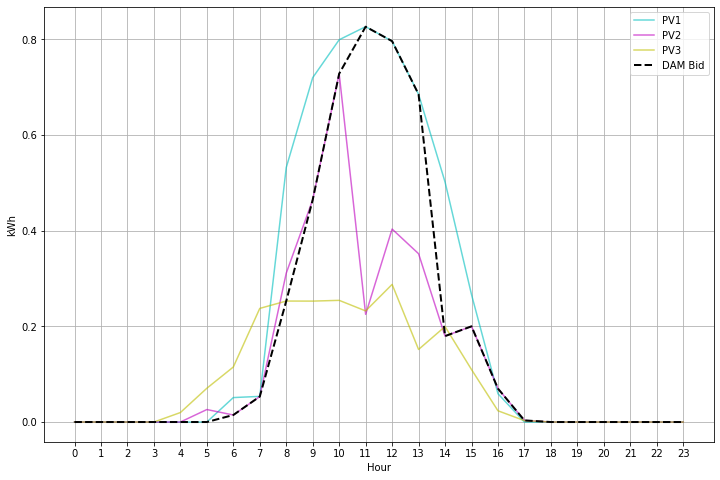

In [58]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(PV1, color='c', alpha=0.6, label='PV1')
ax.plot(PV2, color='m', alpha=0.6, label='PV2')
ax.plot(PV3, color='y', alpha=0.6, label='PV3')
ax.plot(vBidvals, color='k', lw=2, ls='--', label='DAM Bid')
ax.grid()
ax.set_xlabel('Hour')
ax.set_ylabel('kWh')
ax.set_xticks(range(0, 24, 1))
ax.legend()

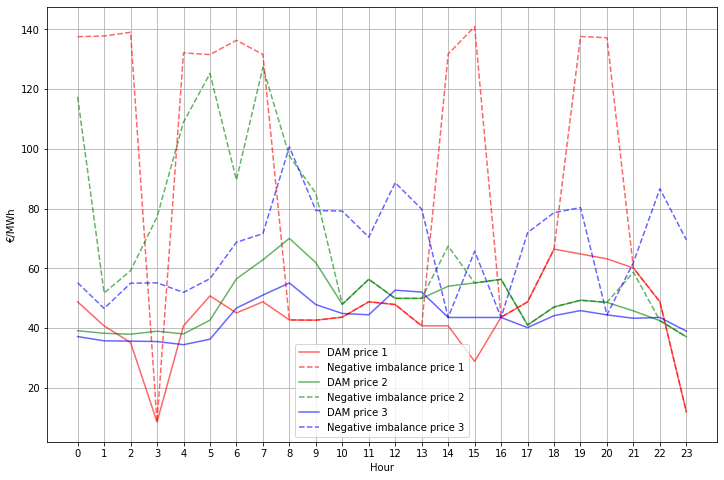

In [51]:
fig, ax = plt.subplots(figsize=(12,8))
alpha_val = 0.6
ax.plot(DAM1, color='red', alpha=alpha_val, label='DAM price 1')
ax.plot(NegImbPrice1, color='red', alpha=alpha_val, ls='--', label='Negative imbalance price 1')
ax.plot(DAM2, color='green', alpha=alpha_val, label='DAM price 2')
ax.plot(NegImbPrice2, color='green', alpha=alpha_val, ls='--', label='Negative imbalance price 2')
ax.plot(DAM3, color='blue', alpha=alpha_val, label='DAM price 3')
ax.plot(NegImbPrice3, color='blue', alpha=alpha_val, ls='--', label='Negative imbalance price 3')
# ax.plot(vBidvals, color='blue', lw=2, ls='--', label='DAM Bid')
ax.grid()
ax.set_xlabel('Hour')
ax.set_ylabel('€/MWh')
ax.set_xticks(range(0, 24, 1))
ax.legend()

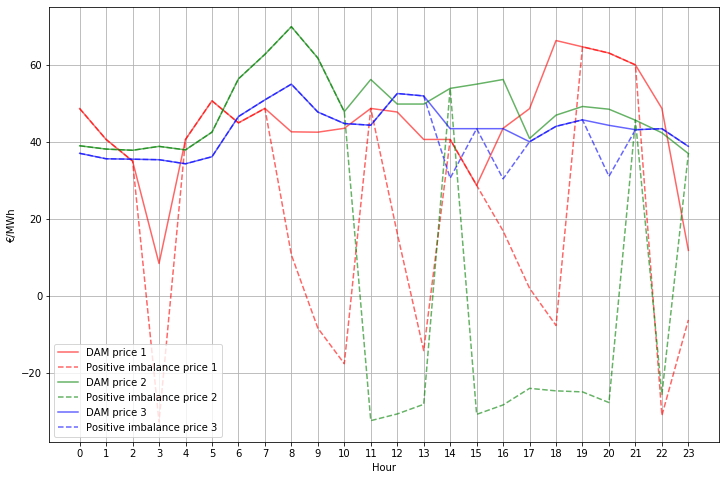

In [53]:
fig, ax = plt.subplots(figsize=(12,8))
alpha_val = 0.6
ax.plot(DAM1, color='red', alpha=alpha_val, label='DAM price 1')
ax.plot(PosImbPrice1, color='red', alpha=alpha_val, ls='--', label='Positive imbalance price 1')
ax.plot(DAM2, color='green', alpha=alpha_val, label='DAM price 2')
ax.plot(PosImbPrice2, color='green', alpha=alpha_val, ls='--', label='Positive imbalance price 2')
ax.plot(DAM3, color='blue', alpha=alpha_val, label='DAM price 3')
ax.plot(PosImbPrice3, color='blue', alpha=alpha_val, ls='--', label='Positive imbalance price 3')
# ax.plot(vBidvals, color='blue', lw=2, ls='--', label='DAM Bid')
ax.grid()
ax.set_xlabel('Hour')
ax.set_ylabel('€/MWh')
ax.set_xticks(range(0, 24, 1))
ax.legend()